In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as ma

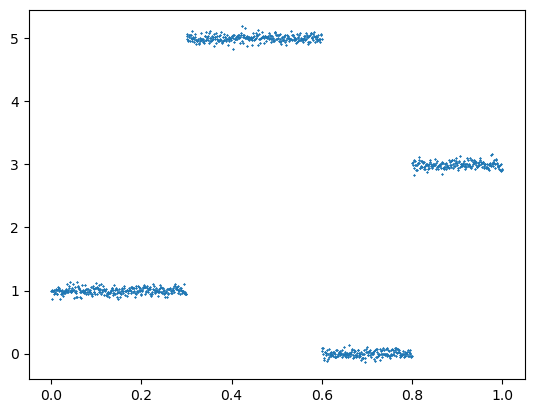

In [3]:
f = np.loadtxt('noisy_signal.csv')
axis = np.linspace(0, 1, num = len(f))




fig, plt_s = plt.subplots()
plt_s.plot(axis, f,'x', markersize = 1)

In [506]:
def func_smooth (t, gamma, omega):
    
    sum = 0
    
    for i in range(0, len(t) ):
        
        if np.abs(t[i]) < 1/gamma:
            sum = sum + omega[i]* gamma * 0.5 * (t[i]**2)
        else:
            sum = sum + omega[i]* (np.abs(t[i]) - (1 /(2*gamma)) )

    return sum
    
def nabla_smooth (t, gamma, omega):

    res = np.zeros_like(t)
    
    for i in range(0, len(t) ):
        res[i] = np.sign(t[i]) * omega[i]
        if np.abs(t[i]) < 1/gamma:
            res[i] = omega[i]* gamma * t[i] 

    return res


def obj_func(u,f, l, z, gamma, omega, gradient = 'True' ):
    '''
    Penalized and smoothed least square simplified.

    Input: 
    x = a vector with the approximation of the signal.
    y = a sparse vector with the aproximation of the steps.
    f = a vector with noisy signals.
    l = a scalar, penalization parameter, how strict we want to be with the smoothness of the denoising
    z = regularization factor, to minimize discrepancies in each iteration.
    omega = penalization for the stepwise function steps.
    
    
    Output:
    x = value of the function.
    '''

    
    n = len(f)
    A = np.eye( n )
    L =  A - np.c_[np.zeros([n,1]) , np.eye( n )[:,:-1] ] 

    
    
    Ahat = np.c_[A, np.zeros((n,n) )]
    Lhat = np.c_[-L , A]

    ##print( np.linalg.eig( np.transpose(Ahat) @ Ahat + np.transpose(Lhat) @ Lhat +max(gamma, 1 )) )

    
    ## estimate the value of the function #################################
    ## first term, signal estimator
    term1 = 0.5 *  ( np.transpose(Ahat@u -f) @ (Ahat@u -f)   )

    ## second term, similarity of xi with xi+1
    ## y allowance for steps.
    ## z regularization factor, sort of a restraint belt
    term2 = ( 0.5 * l ) * ( np.transpose(Lhat@u -z) @ (Lhat@u -z)   )

    ## penalization of y, to ensure a sparse y to penalize this steps
    term3 = func_smooth(u,gamma, omega)

    res = term1 + term2 + term3
    
    ## estimate the derivative of the function #################################

    if gradient == 'True':
        dterm1 = (  np.transpose(Ahat) @ Ahat   + l * np.transpose(Lhat) @ Lhat  )  @ u
        dterm2 = - (  np.transpose(Ahat) @ f   + l * np.transpose(Lhat) @ z  )
        dterm3 = nabla_smooth(u,gamma, omega)
    
        nabla = dterm1 + dterm2 + dterm3
        
        return res, nabla  
    else:
        return res


def lipschitz_bound(n, gamma):
    ''' Estimate a sensible lipschitz bound for the hessian of the denoising function, with n elements.
    '''


    A = np.eye( n )
    L =  A - np.c_[np.zeros([n,1]) , np.eye( n )[:,:-1] ]

    
    
    Ahat = np.c_[A, np.zeros((n,n) )]
    Lhat = np.c_[-L , A]

    ##print( np.linalg.eig( np.transpose(Ahat) @ Ahat + np.transpose(Lhat) @ Lhat +max(gamma, 1 )) )

    return np.linalg.norm( np.transpose(Ahat) @ Ahat + np.transpose(Lhat) @ Lhat +max(gamma, 1) )##, 'fro')




In [508]:
def variational_denoise_backtracking(f, l, gamma, om, alpha, beta):
    '''
    Gradient descend to minimize the variational denoise function. This functions optimizes both x and y coupled
    The function utilizes the Hubber loss function to penalize y, the vector of steps.

    Input: 
    f = a vector with noisy signals.
    l = a scalar, penalization parameter, how strict we want to be with the smoothness of the denoising
    gamma = smoothing factor for approximation of norm-1
    omega = penalization for the stepwise function steps. (?? Idea for development, penalization could be smaller depending 
            on the distance to the mean ?? )
    
    
    Output:
    x = value of the function.

    '''

    ##  INITIALIZATION :problem initializes creating required variables and parameters ########################
    ###########################################################################################################
    ###########################################################################################################
    n = len(f)
    ss = .01
    
    x = np.average(f) * np.ones(n)
    y = np.std(f) * np.ones(n)
    z = np.zeros(len(x))
    u = np.concatenate((x,y))
    
    u.resize((len(u), 1))
    x.resize((len(x), 1))
    y.resize((len(y), 1))
    z.resize((len(z), 1))

    omega = om * np.concatenate( (np.zeros(len(x)),np.ones(len(x))) )
    
    Lb =  lipschitz_bound(n, gamma)
    print(Lb)

    A = np.eye( n )
    L =  A - np.c_[np.zeros([n,1]) , np.eye( n )[:,:-1] ]

   
    
    ##  END INITIALIZATION ####################################################################################
    ###########################################################################################################
    ###########################################################################################################
    
    ##  X first iter ##########################################################################################
    ###########################################################################################################
    ###########################################################################################################

    ## U FIRST ITER of x first iter ##
    
    
    ## DESCEND DIRECTION descend update for u
    fu, d = obj_func(u,f, l, z, gamma, omega )
    dn = - d / np.linalg.norm(d)
    
    ## STEP SIZE first backtracking 
    
    s = 1
    b_i= 0
    uk = u + (s* beta**b_i ) * dn 
    fuk = obj_func(uk,f, l, z, gamma, omega, False )

    print(fu, fuk, d.shape, dn.shape,np.dot(d.T,dn))
    while fuk > fu + alpha * (s* beta**b_i ) * np.dot(d.T,dn):
        b_i = b_i+1
        uk = u + (s* beta**b_i ) * dn 
        fuk = obj_func(uk,f, l, z, gamma, omega, False )

    ## U while of x first iter ##
    j = 0
    while np.linalg.norm(uk - u) / (np.linalg.norm(uk)+ 1e-10)  > .0001  and j <100:
    
        j = j+1
        u = uk
     
        ## descend direction update
        fu, d = obj_func(u,f, l, z, gamma, omega)
        dn = - d / np.linalg.norm(d)

        ##backtracking
        b_i= 0
        uk = u + (s* beta**b_i ) * dn 
        fuk = obj_func(uk,f, l, z, gamma, omega, False )
        
        while fuk > fu + alpha * (s* beta**b_i ) * np.dot(d.T,dn):
            b_i = b_i+1
            uk = u + (s* beta**b_i ) * dn 
            fuk = obj_func(uk,f, l, z, gamma, omega, False )


    ## last uk has enough descend or reached maximum iters
    xk = uk[0:n]
    yk = uk[n:]

    
    
    ##  END X first iter ######################################################################################
    ###########################################################################################################
    ###########################################################################################################

    ##  X loop ################################################################################################
    ###########################################################################################################
    ###########################################################################################################
    axis = np.linspace(0, 1, num = len(f2))
    fig, plt_s = plt.subplots()
    plt_s.plot(axis, f2,'x', markersize = .5)
    plt_s.plot(axis, x) 
    
    
    iter = 0
    flag = 1
    while flag  > .00001 and iter < 100: ##<---------------------------------------------------------------------iteración sobre x
        
        if n > 100:
            _, grad = obj_func(u,f, l, z, gamma, omega )
            print(iter, flag, np.linalg.norm(xk - x) / ( np.linalg.norm(xk)+ 1e-10), np.linalg.norm(grad), fu )
        iter = iter+1
        
        z = z + L @ xk - yk
        x = xk
        y = yk
        u = uk

        ## U FIRST ITER ##
        
        ## descend update for u
        fu, d = obj_func(u,f, l, z, gamma, omega )
        dn = - d / np.linalg.norm(d)
        
        ## first backtracking
        s = 1
        b_i= 0
        uk = u + (s* beta**b_i ) * dn 
        fuk = obj_func(uk,f, l, z, gamma, omega, False )
        while fuk > fu + alpha * (s* beta**b_i ) * np.dot(d.T,dn):
            b_i = b_i+1
            uk = u + (s* beta**b_i ) * dn 
            fuk = obj_func(uk,f, l, z, gamma, omega, False )
    
        ##bactracking end, uk guarantees descend we update x, y, z 
        j = 0
        while np.linalg.norm(uk - u) / (np.linalg.norm(uk)) > .0001 and j <500:
        
            j = j+1
            u = uk
     
            ## descend direction update
            fu, d = obj_func(u,f, l, z, gamma, omega)
            dn = - d / np.linalg.norm(d)

            ## backtracking
            s = 1
            b_i= 0
            uk = u + (s* beta**b_i ) * dn 
            fuk = obj_func(uk,f, l, z, gamma, omega, False )
            while fuk > fu + alpha * (s* beta**b_i ) * np.dot(d.T,dn):
                b_i = b_i+1
                uk = u + (s* beta**b_i ) * dn 
                fuk = obj_func(uk,f, l, z, gamma, omega, False )
            
                xk = uk[0:n]
                yk = uk[n:]
            plt_s.plot(axis, x)   
        flag = np.linalg.norm(xk - x) / ( np.linalg.norm(xk)+ 1e-10)
        

    print(iter, flag, np.linalg.norm(xk - x) / ( np.linalg.norm(xk)+ 1e-10), np.linalg.norm(grad), fu )
    
    
    return  xk, yk
    

2000001.0034974983
[[194269.71195386]] [[188109.64099297]] (2000, 1) (2000, 1) [[-6210.39034275]]
0 1 0.20687098081667582 51.17687578272384 [[1068.79832359]]
1 0.4354889618615827 0.4354889618615827 7.318350969785281 [[17.33751915]]
2 0.008746554127881176 0.008746554127881176 10.381728449857572 [[13.86616838]]
3 0.00014096916744246458 0.00014096916744246458 8.082584065049426 [[13.83360765]]
4 0.0009585286807492249 0.0009585286807492249 4.724709658755737 [[13.45069556]]
5 0.0012937640853940674 0.0012937640853940674 5.4672347362113 [[13.02912413]]
6 0.0011296238581631037 0.0011296238581631037 5.515089793498617 [[12.65420029]]
7 0.0003660981358172192 0.0003660981358172192 4.33724218199355 [[12.51929871]]
8 0.0002477424397444716 0.0002477424397444716 4.011758028893727 [[12.43414489]]
9 0.0008616743801151395 0.0008616743801151395 6.1685412944366815 [[12.1717185]]
10 0.0 0.0 6.1685412944366815 [[12.16724996]]


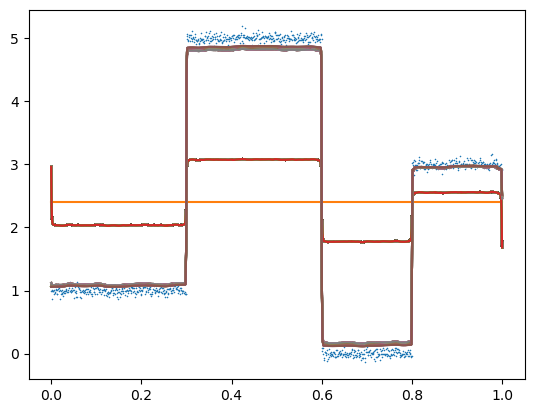

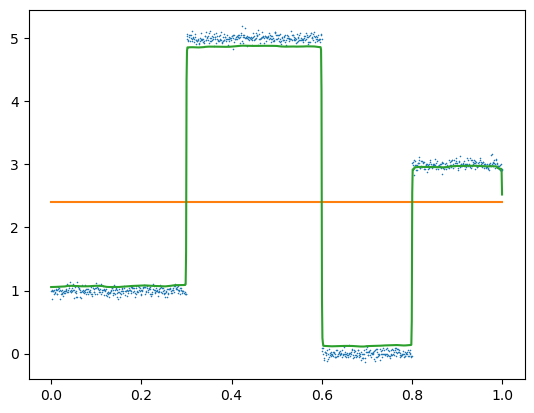

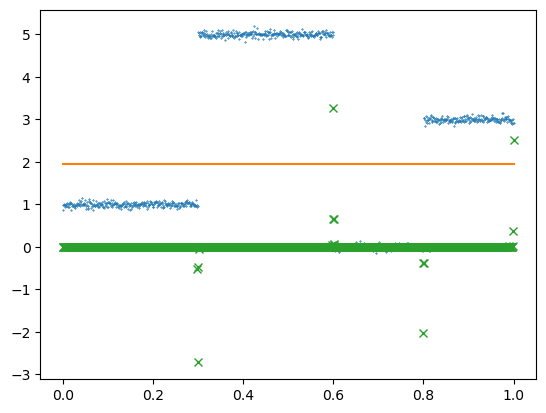

In [512]:
n = 250



f2 = np.array([1.02,.98,.99,1.012,1.001, 5.15,4.95,5.2,4.95,5.001, 0.01,-0.01,0.1,0.03,-.003,2.99,3.01,3.011, 2.992,3.1])

f2 = f

x = np.average(f2) * np.ones(len(f2) )
y = np.std(f2) * np.ones(len(f2))
l = 100
z = np.zeros(len(f2))
gamma = 1000
om = .3
alpha = .8
beta = .7



f2.resize((len(f2), 1))
z.resize((len(z), 1))


x2, y2 = variational_denoise_backtracking(f2, l, gamma, om, alpha, beta)


axis = np.linspace(0, 1, num = len(f2))
fig, plt_s = plt.subplots()
plt_s.plot(axis, f2,'x', markersize = .5)
plt_s.plot(axis, x)
plt_s.plot(axis, x2)


fig, plt_s2 = plt.subplots()
plt_s2.plot(axis, f2,'x', markersize = 1, alpha = .7)
plt_s2.plot(axis, y)
plt_s2.plot(axis, y2,'x')


#print(iter, np.linalg.norm(xk - x) / ( np.linalg.norm(xk)+ 1e-10), np.linalg.norm(grad), fu )